In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 

In [3]:
df = pd.read_csv('heart.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [4]:
df.shape

(918, 12)

In [5]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

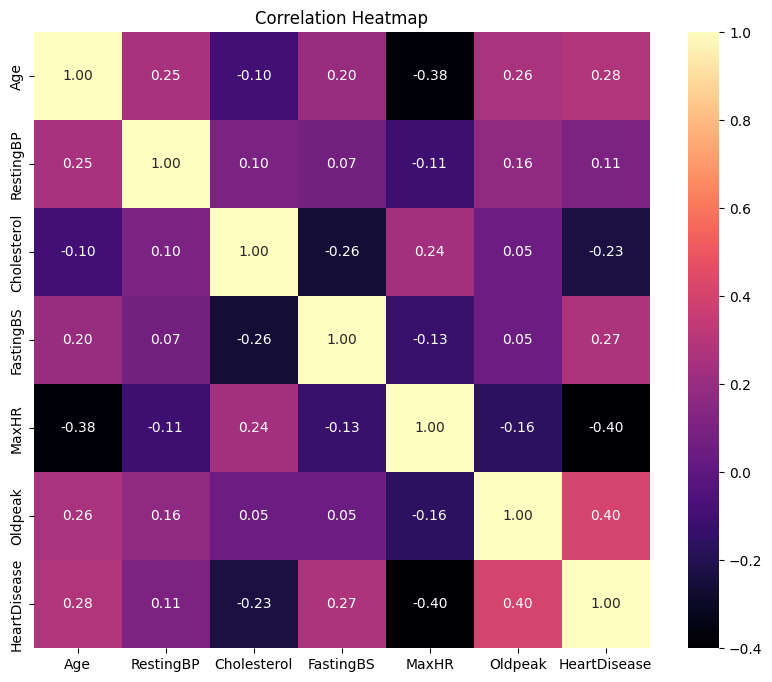

In [6]:
corr = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='magma', square=True)
plt.title('Correlation Heatmap')
plt.show()

# Data Splitting

In [7]:
def train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True):
    if len(arrays) == 0:
        raise ValueError("At least one array required.")

    n_samples = len(arrays[0])
    for arr in arrays:
        if len(arr) != n_samples:
            raise ValueError("All input arrays must have the same length.")

    if isinstance(random_state, int):
        rng = np.random.RandomState(random_state)
    else:
        rng = np.random if random_state is None else random_state

    if test_size is None and train_size is None:
        test_size = 0.25

    if test_size is not None:
        if isinstance(test_size, float):
            n_test = int(np.ceil(test_size * n_samples))
        else:
            n_test = int(test_size)
    else:
        n_test = n_samples - int(train_size)

    n_train = n_samples - n_test

    if shuffle:
        indices = rng.permutation(n_samples)
    else:
        indices = np.arange(n_samples)

    train_indices = indices[:n_train]
    test_indices = indices[n_train:]

    result = []
    for arr in arrays:
        result.append(np.array(arr)[train_indices])
        result.append(np.array(arr)[test_indices])

    return result

In [8]:
X = df.drop("MaxHR", axis = 1)
Y = df["MaxHR"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(Y_train.shape)

(734, 11)
(184, 11)
(184,)
(734,)


# Linear Regression

In [10]:
def compute_cost_linear(X, y, w, b, lambda_=1):
    m = X.shape[0]
    cost = 0 
    for i in range(m):
        f_wb_i = np.dot(X[i], w) + b
        cost += (f_wb_i - y[i])**2
    cost /= (2 * m)

    # Regularization term
    reg_cost = (lambda_ / (2 * m)) * np.sum(w**2)
    total_cost = cost + reg_cost
    return total_cost

In [11]:
def compute_gradient_linear_reg(X, y, w, b, lambda_):
    m, n = X.shape           
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i]                 
        for j in range(n):                         
            dj_dw[j] += err * X[i, j]               
        dj_db += err                        
    dj_dw /= m                                
    dj_db /= m   
    
    # Regularization term
    dj_dw += (lambda_ / m) * w

    return dj_dw, dj_db

In [12]:

def gradient_descent(x, y, w_init, b_init, learning_rate, iterations, lambda_=1):
    w = w_init
    b = b_init
    for i in range(iterations):
        dj_dw, dj_db = compute_gradient_linear_reg(x, y, w, b, lambda_)

        # Update parameters
        w = w - learning_rate * dj_dw
        b = b - learning_rate * dj_db

        if i % 100 == 0 or i == iterations - 1:
            cost = compute_cost_linear(x, y, w, b, lambda_)
            w_str = ", ".join([f"{wi:.4f}" for wi in w])
            print(f"Iteration {i+1}: Cost = {cost:.4f}, w = [{w_str}], b = {b:.4f}")
        
    return w, b

In [13]:
X_columns = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 
             'RestingECG', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']
X_train_df = pd.DataFrame(X_train, columns=X_columns)
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
X_train_encoded = pd.get_dummies(X_train_df, columns=categorical_cols, drop_first=True)
# Convert to float for normalization
X_train_encoded = X_train_encoded.astype(float)

# Normalize data
X_mean = X_train_encoded.mean(axis=0)
X_std = X_train_encoded.std(axis=0)
X_train_norm = (X_train_encoded - X_mean) / X_std

w_init = np.zeros(X_train_norm.shape[1])
b_init = 0
learning_rate = 0.01  
iterations = 5000
w, b = gradient_descent(X_train_norm.values, Y_train, w_init, b_init, learning_rate, iterations)

Iteration 1: Cost = 9502.0547, w = [-0.0984, -0.0274, 0.0591, -0.0369, -0.0490, -0.1071, -0.0513, 0.0752, 0.0330, 0.0211, 0.0064, -0.0365, -0.0964, -0.0897, 0.1004], b = 1.3676


Iteration 101: Cost = 1457.1973, w = [-4.5384, -0.8446, 2.7015, -0.5152, 0.0451, -2.6787, -1.5518, 2.2450, 1.6850, 1.3509, -1.0379, -1.5495, -3.1368, -2.2201, 2.4035], b = 87.2021
Iteration 201: Cost = 386.6773, w = [-6.0626, -0.9059, 3.3385, -0.0258, 1.0781, -2.4155, -1.6278, 2.6306, 2.3897, 1.8908, -2.0700, -2.1919, -3.6527, -2.2249, 2.3294], b = 118.6204
Iteration 301: Cost = 241.9815, w = [-6.8272, -0.8956, 3.5177, 0.2856, 1.6472, -2.1085, -1.6234, 2.9369, 2.8057, 2.1326, -2.7174, -2.6627, -3.9025, -2.2439, 2.3168], b = 130.1204
Iteration 401: Cost = 222.0721, w = [-7.2300, -0.8724, 3.5499, 0.4504, 1.9526, -1.8557, -1.6193, 3.1794, 3.0676, 2.2533, -3.1396, -3.0070, -4.0328, -2.2682, 2.3448], b = 134.3298
Iteration 501: Cost = 219.1728, w = [-7.4491, -0.8522, 3.5361, 0.5305, 2.1170, -1.6579, -1.6218, 3.3615, 3.2396, 2.3211, -3.4240, -3.2546, -4.0990, -2.2843, 2.3847], b = 135.8706
Iteration 601: Cost = 218.6752, w = [-7.5722, -0.8380, 3.5113, 0.5666, 2.2056, -1.5066, -1.6281, 3.4949

# Predicted vs Actual

In [14]:
# Predict function
def predict(X, w, b):
    return np.dot(X, w) + b

# Predict on train data
Y_pred = predict(X_train_norm, w, b)

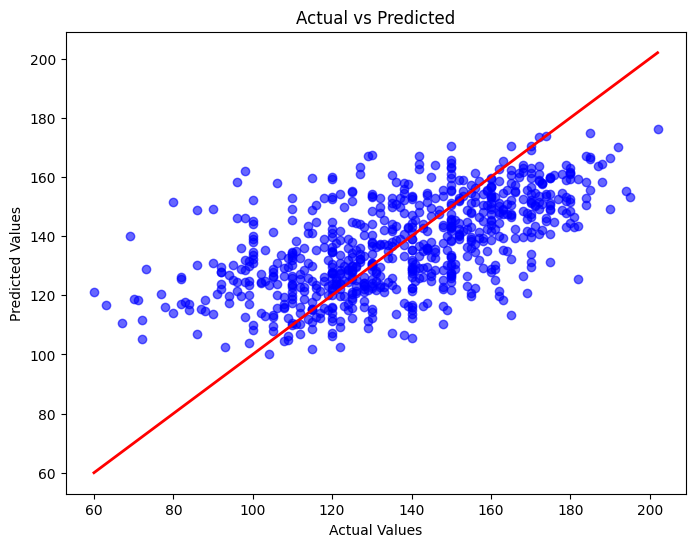

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_train, Y_pred, color='blue', alpha=0.6)
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], color='red', linewidth=2)  # y = x line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()

# Logistic Regression

In [16]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [17]:
def compute_cost_logistic_reg(X, y, w, b, lambda_ = 1):
    m,n  = X.shape
    cost = 0.
    for i in range(m):
        z_i = np.dot(X[i], w) + b                                      
        f_wb_i = sigmoid(z_i)                                          
        cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)      
             
    cost = cost/m                                                      
    reg_cost = 0
    for j in range(n):
        reg_cost += (w[j]**2)                                          
    reg_cost = (lambda_/(2*m)) * reg_cost                              
    
    total_cost = cost + reg_cost                                       
    return total_cost

In [18]:
def compute_gradient_logistic_reg(X, y, w, b, lambda_): 
    m,n = X.shape
    dj_dw = np.zeros((n,))                            
    dj_db = 0.0                                      

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          
        err_i  = f_wb_i  - y[i]                      
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   
    dj_db = dj_db/m                                   

    for j in range(n):
        dj_dw[j] = dj_dw[j] + (lambda_/m) * w[j]

    return dj_db, dj_dw

In [19]:
def gradient_descent_log(x, y, w_init, b_init, learning_rate, iterations, lambda_=1):
    w = w_init
    b = b_init
    for i in range(iterations):
        dj_db, dj_dw = compute_gradient_logistic_reg(x, y, w, b, lambda_)

        # Update parameters
        w = w - learning_rate * dj_dw
        b = b - learning_rate * dj_db

        if i % 100 == 0 or i == iterations - 1:
            cost = compute_cost_logistic_reg(x, y, w, b, lambda_)
            w_flat = w.flatten()
            w_str = ", ".join([f"{float(wi):.4f}" for wi in w_flat])
            print(f"Iteration {i+1}: Cost = {cost:.4f}, w = [{w_str}], b = {b:.4f}")

    return w, b

In [20]:
# Binary target: HeartDisease
df['target'] = df['HeartDisease'].astype(int)
X_log = df.drop(['HeartDisease', 'target'], axis=1)
X_log = pd.get_dummies(X_log, columns=categorical_cols, drop_first=True).astype(float).values
Y_log = df['target'].values
X_train_log, X_test_log, Y_train_log, Y_test_log = train_test_split(X_log, Y_log, test_size=0.2, random_state=42)

# Normalisation for logistic regression
X_mean_log = np.mean(X_train_log, axis=0)
X_std_log = np.std(X_train_log, axis=0)
X_train_log_norm = (X_train_log - X_mean_log) / X_std_log

# Initialize
w_init = np.zeros(X_train_log_norm.shape[1])
b_init = 0.0
learning_rate = 0.02  
iterations = 10000

# Train logistic regression
w, b = gradient_descent_log(X_train_log_norm, Y_train_log, w_init, b_init, learning_rate, iterations)

Iteration 1: Cost = 0.6843, w = [0.0026, 0.0009, -0.0021, 0.0026, -0.0041, 0.0040, 0.0031, -0.0041, -0.0023, -0.0005, -0.0009, 0.0009, 0.0049, 0.0054, -0.0062], b = 0.0013
Iteration 101: Cost = 0.3992, w = [0.1149, 0.0364, -0.1257, 0.1516, -0.1965, 0.2083, 0.1876, -0.2302, -0.1645, -0.0388, -0.0338, 0.0362, 0.2596, 0.2868, -0.3297], b = 0.1069
Iteration 201: Cost = 0.3572, w = [0.1382, 0.0435, -0.1855, 0.2221, -0.2454, 0.2749, 0.2820, -0.3281, -0.2688, -0.0678, -0.0349, 0.0379, 0.3503, 0.3829, -0.4421], b = 0.1781
Iteration 301: Cost = 0.3419, w = [0.1437, 0.0474, -0.2239, 0.2682, -0.2589, 0.3061, 0.3471, -0.3910, -0.3483, -0.0929, -0.0321, 0.0340, 0.3968, 0.4299, -0.4970], b = 0.2314
Iteration 401: Cost = 0.3340, w = [0.1439, 0.0512, -0.2509, 0.3017, -0.2588, 0.3229, 0.3961, -0.4374, -0.4124, -0.1154, -0.0290, 0.0288, 0.4242, 0.4572, -0.5282], b = 0.2734
Iteration 501: Cost = 0.3293, w = [0.1423, 0.0555, -0.2709, 0.3274, -0.2527, 0.3327, 0.4344, -0.4742, -0.4653, -0.1357, -0.0265, 0.0

In [21]:
def predict_logistic(X, w, b):
    probs = sigmoid(np.dot(X, w) + b)
    return (probs >= 0.5).astype(int)

# Normalize test data using train mean/std
X_train_log_norm = (X_train_log - X_mean_log) / X_std_log

# Predict on test set
Y_pred_log = predict_logistic(X_train_log_norm, w, b)

# Accuracy
accuracy = np.mean(Y_pred_log == Y_train_log)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8747


# Problem


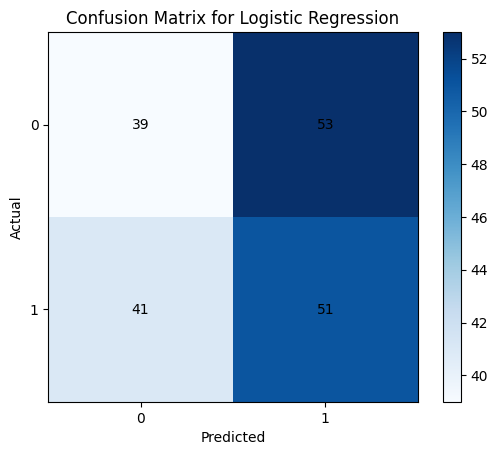

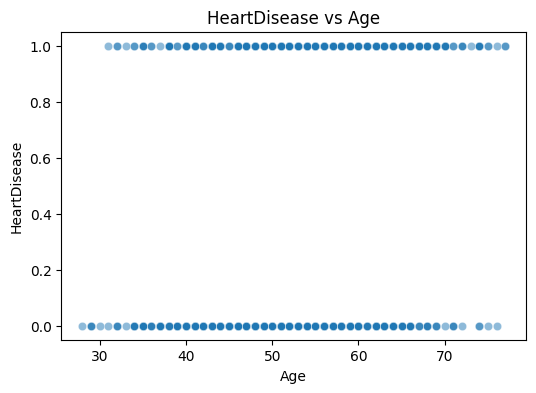

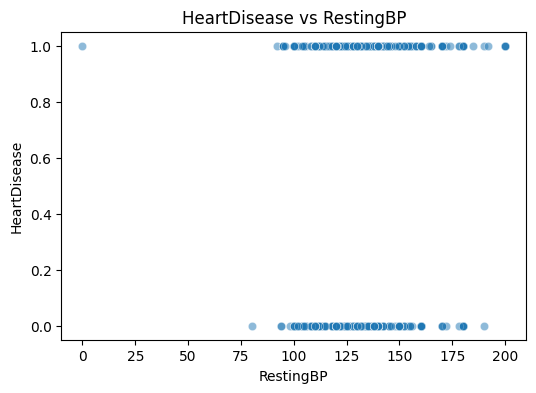

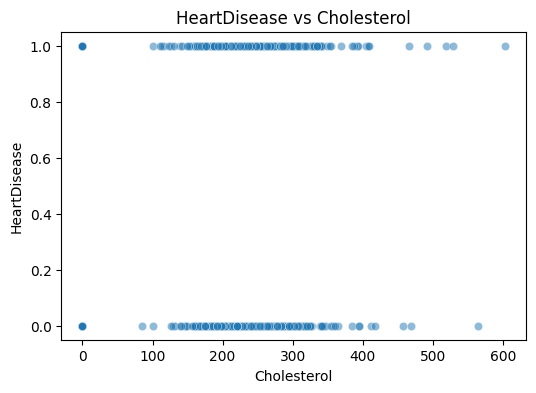

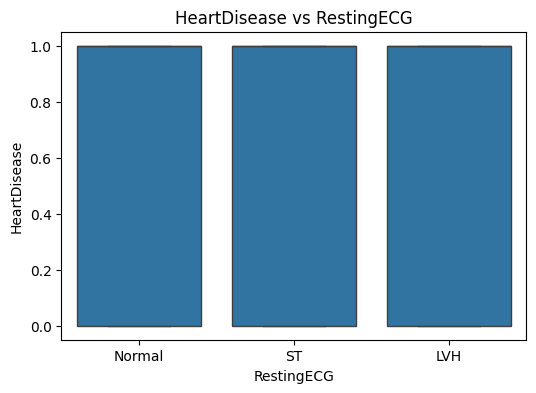

In [28]:
def plot_confusion_matrix(y_true, y_pred, labels=[0, 1]):
    cm = np.zeros((2, 2), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix for Logistic Regression")
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
    plt.colorbar(im)
    plt.show()

plot_confusion_matrix(Y_test_log, Y_pred_log)

# Plot HeartDisease with clinical features
features = ['Age', 'RestingBP', 'Cholesterol', 'RestingECG']
for feat in features:
    plt.figure(figsize=(6, 4))
    if df[feat].dtype == 'object':
        sns.boxplot(x=df[feat], y=df['HeartDisease'])
    else:
        sns.scatterplot(x=df[feat], y=df['HeartDisease'], alpha=0.5)
    plt.title(f'HeartDisease vs {feat}')
    plt.ylabel('HeartDisease')
    plt.xlabel(feat)
    plt.show()
